##### imports

In [384]:
from numpy import exp
from numpy import sqrt
from numpy import cos, sin
from numpy import e
from numpy import pi
from typing import List, Callable, Tuple
import random

#### Definindo váriaveis e função de avaliação

In [385]:
A = 20
B = 0.2
C = 2 * pi
D = 30

In [386]:
TAM_DA_POPULACAO = 30
QTD_DE_FILHOS = 7 * TAM_DA_POPULACAO
POPULACAO = []
TAXA_APRENDIZAGEM = 1 / sqrt(D)
EPSILON_0 = 0.001
EPSILON_1 = 10
MAX_ITERS = 200
NUM_EXEC = 50
LIM_DE_ITER_SEM_MELHORA = 25
CURR_SUCCESS = 0
FITNESS_FUNC = None
CROSSOVER_FUNC = None
SURV_SELECTION_FUNC = None
RANGE_XI = (-15,15)

In [387]:
def ackley_funct(x: List[float]):
  return - A * exp(-B * sqrt(sum(map(lambda n: n ** 2, x)) / D)) \
          - exp(sum(map(lambda n: cos(C * n), x)) / D) \
          + A + exp(1)

In [388]:
def schwefel_funct(x: List[float]):
    return 418.9829 * D - sum(map(lambda n: n * sin(sqrt(abs(n))), x))

In [389]:
def sum_squares_function(x: List[float]):
    soma = 0

    for i in range(D):
        soma += (i+1) * x[i] ** 2

    return soma

In [390]:
FITNESS_FUNC = sum_squares_function

In [391]:
def fitness(fitness_func: Callable, cromossome: List[float]):
    return fitness_func(cromossome)

In [392]:
print(f'{ackley_funct([0 for _ in range(30)]) : .15f}')

 0.000000000000000


# Estratégia Evolutiva

## Inicialização da população

In [393]:
def generate_individual():
  x = []
  for i in range(D):
    x.append(random.uniform(RANGE_XI[0], RANGE_XI[1]))
    
  return x

In [394]:
def generate_population():
  global POPULACAO, TAM_DA_POPULACAO
  
  for _ in range(TAM_DA_POPULACAO):
    POPULACAO.append((generate_individual(), random.normalvariate(0, 1)))

In [395]:
def reset_population() -> None:
    global POPULACAO

    POPULACAO = []

## Seleção de pais

In [396]:
def select_parents():
    global POPULACAO

    pai1, pai2 = random.sample(POPULACAO, 2)

    return pai1, pai2

## Recombinação

In [397]:
def evolutive_crossover(pai1: Tuple[List[float], float], pai2: Tuple[List[float], float]):
    global CROSSOVER_FUNC
    return CROSSOVER_FUNC(pai1, pai2)

In [398]:
def local_intermediary(pai1: Tuple[List[float], float], pai2: Tuple[List[float], float]):
    filho = []
    for i in range(D):
        filho += [(pai1[0][i] + pai2[0][i])/2]
        
    sigma = (pai1[1] + pai2[1])/2

    return filho, sigma

In [399]:
def local_discrete(pai1: Tuple[List[float], float], pai2: Tuple[List[float], float]):
    filho = []
    for i in range(D):
        filho += random.sample([pai1[0][i], pai2[0][i]], 1)
        
    sigma = random.sample([pai1[1], pai2[1]], 1)[0]

    return filho, sigma

In [400]:
CROSSOVER_FUNC = local_intermediary

In [401]:
def crossover():
    global QTD_DE_FILHOS

    filhos = []
    for _ in range(QTD_DE_FILHOS):
        pai1, pai2 = select_parents()
        filhos.append(evolutive_crossover(pai1, pai2))

    return filhos

## Mutação

In [402]:
def regra_1_quinto(sigma: float, sucesso: float) -> float:
    c = 0.8
    
    if sucesso > 1 / 5:
        sigma = sigma / c
    elif sucesso < 1 / 5:
        sigma = sigma * c
    
    return sigma

In [403]:
def calc_sigma(sigma: float) -> float:
    global TAXA_APRENDIZAGEM, EPSILON_0, EPSILON_1

    new_sigma = sigma * exp(TAXA_APRENDIZAGEM * random.normalvariate(0, 1))

    return min(max(new_sigma, EPSILON_0), EPSILON_1)

In [404]:
def test_success(old_indiv_fitness, new_indiv_fitness):
    global CURR_SUCCESS

    if new_indiv_fitness < old_indiv_fitness:
        CURR_SUCCESS += 1

In [405]:
def get_success() -> float:
    global CURR_SUCCESS
    
    return CURR_SUCCESS / QTD_DE_FILHOS

In [406]:
def reset_success() -> None:
    global CURR_SUCCESS

    CURR_SUCCESS = 0

In [407]:
def mutate_and_calc_sucess(individuo: List[float], sigma: float):
    global FITNESS_FUNC
    
    novo_sigma = calc_sigma(sigma)

    old_fitness = fitness(FITNESS_FUNC, individuo)
    
    for i in range(len(individuo)):
        individuo[i] = min(max(individuo[i] + novo_sigma * random.normalvariate(0, 1), RANGE_XI[0]), RANGE_XI[1])

    new_fitness = fitness(FITNESS_FUNC, individuo)
    test_success(old_fitness, new_fitness)

    return individuo, novo_sigma

In [408]:
def mutate(filhos: List[Tuple[List[float], float]]):
    global QTD_DE_FILHOS

    filhos_mutados = []
    for i in range(QTD_DE_FILHOS):
            filhos_mutados.append(mutate_and_calc_sucess(filhos[i][0], filhos[i][1]))

    return filhos_mutados

## Seleção de sobreviventes

#### Geracional

In [409]:
def generational(filhos: List[Tuple[List[float], float]], iteration):
    global POPULACAO, FITNESS_FUNC, TAM_DA_POPULACAO
    reset_population()
    
    filhos.sort(key=lambda filho: fitness(FITNESS_FUNC, filho[0]), reverse=False)
    POPULACAO = filhos[:TAM_DA_POPULACAO]

In [410]:
def elitist(filhos: List[Tuple[List[float], float]], iteration):
    global POPULACAO, FITNESS_FUNC, TAM_DA_POPULACAO
    
    POPULACAO += filhos
    POPULACAO.sort(key=lambda filho: fitness(FITNESS_FUNC, filho[0]), reverse=False)
    POPULACAO = POPULACAO[:TAM_DA_POPULACAO]

In [411]:
SURV_SELECTION_FUNC = generational

## Condição de parada

In [412]:
def is_close(a: float, b: float, diff: float = 0.005):
    if a + diff > b and b + diff > a:
        return True
        
    return False

In [413]:
def should_stop(curr_best_fitness: float, curr_iter: int, iter_sem_melhora: int):
    global MAX_ITERS, LIM_DE_ITER_SEM_MELHORA
    if is_close(curr_best_fitness, 0):
        return True
    if curr_iter == MAX_ITERS:
        return True
    if iter_sem_melhora == LIM_DE_ITER_SEM_MELHORA:
        return True

    return False

## Evolução

In [414]:
def generate_solution():
    global POPULACAO, TAM_DA_POPULACAO, FITNESS_FUNC

    iteration = 0
    best_fitness = float("inf")
    curr_best_fitness = float("inf")
    best_solution = None
    bests_fitness = []
    bests_sigma = []

    iter_sem_melhora = 0

    reset_population()
    generate_population()    

    while (not should_stop(best_fitness, iteration, iter_sem_melhora)):
        reset_success()

        filhos = crossover()    
        filhos = mutate(filhos)

        success = get_success()

        for i in range(len(filhos)):
            filhos[i] = (filhos[i][0], regra_1_quinto(filhos[i][1], success))

        SURV_SELECTION_FUNC(filhos, iteration)        

        if (abs(curr_best_fitness-fitness(FITNESS_FUNC, POPULACAO[0][0]))) > 0.0005:
            iter_sem_melhora = 0
        else: 
            iter_sem_melhora += 1

        curr_best_fitness = fitness(FITNESS_FUNC, POPULACAO[0][0])
        bests_fitness.append(curr_best_fitness)
        bests_sigma.append(POPULACAO[0][1])

        if curr_best_fitness <= best_fitness:
            best_fitness = curr_best_fitness
            best_solution = POPULACAO[0][0]

        iteration += 1

    return best_fitness, best_solution, bests_fitness, bests_sigma, iteration


## Resultados

In [415]:
import matplotlib.pyplot as plt
import numpy as np

In [416]:
def plot_results(best_fitness, best_solution, bests_fitness, bests_sigma, iteration) -> None:
    fig = plt.figure(figsize=(12, 6))
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    fig.suptitle('Evolution x iteration')
    
    # Fitness
    ax1.plot(range(0,iteration), bests_fitness)
    ax1.set(xlabel='iteration', ylabel='melhor fitness',ylim = 0,
           title='fitness evolution')
    ax1.grid()

    # Desvio Padrão
    ax2.plot(range(0,iteration), bests_sigma)
    ax2.set(xlabel='iteration', ylabel='melhor desvio padrão',
           title='sigma evolution')
    ax2.grid()

    fig.tight_layout()
    plt.show()

    print(best_fitness, best_solution)

In [417]:
def run_executions():
    num_exec_com_sucesso = 0
    best_result = [float("inf"), None, None, None, None]
    bests_fitness = []
    
    for i in range(NUM_EXEC):
        results = generate_solution()
        bests_fitness.append(results[0])
    
        if is_close(results[0], 0):
            num_exec_com_sucesso += 1

        if best_result[0] > results[0]:
            best_result[0] = results[0] # Melhor fitness da execução
            best_result[1] = results[1] # Solução com melhor fitness da execução
            best_result[2] = results[2] # Evolução do melhor fitness da execução com melhor fitness
            best_result[3] = results[3] # Evolução do sigma do melhor fitness da execução com melhor fitness
            best_result[4] = results[4] # iteração de parada da execução com melhor fitness
        
        print(f'{results[0] : .4f}', f'{results[4] : .4f}', end=" ")
    
    plot_results(best_result[0], best_result[1], best_result[2], best_result[3], best_result[4])
    
    print("Média:", np.mean(bests_fitness))
    print("Desvio Padrão:", np.std(bests_fitness))
    print("Execuções com sucesso:", num_exec_com_sucesso, "de", NUM_EXEC)

### Resultados com função de ACKLEY

In [418]:
RANGE_XI=(-15,15)

6.255854683414537 69 3.0268394129101535 76 2.1201194713335743 76 3.5741623251873915 84 4.2553533349461965 78 5.762091737025596 71 4.3409920967924975 72 2.66055890959915 80 5.473379587085425 70 3.934485951830386 76 3.5187249389317015 78 4.775076783266691 73 2.495927015880391 75 3.3449223744738963 81 5.620785920764522 75 3.7341828683171028 76 5.678214013609161 66 3.0268185732463775 79 3.461937262935326 75 2.2201750751850686 83 4.623656784386959 77 2.1201108894486755 80 2.4954580971879605 76 4.2115865925294145 74 3.681619499176453 80 3.5183722432087774 75 6.77781132259129 73 3.4043108810938922 73 5.3193628410691005 71 5.319307533394287 74 6.44540087692992 74 4.737756134480758 73 2.3169184501770244 75 4.623966072681096 73 5.350761548565568 71 4.5848230027488235 74 5.734572857650097 69 2.8141513155735294 91 4.584991558563175 73 3.628645476501433 76 2.408386779512274 79 1.89981098318917 82 4.340910348871809 74 5.978107257181229 74 4.737735733292215 78 5.158318884452587 72 3.0936598463604104 

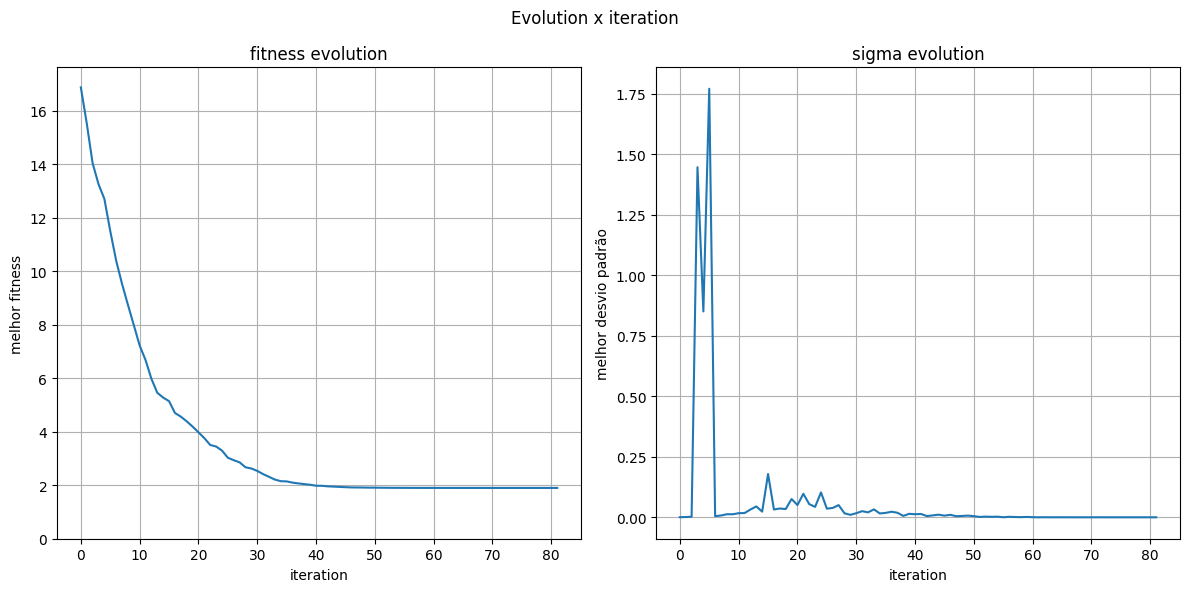

1.89981098318917 [-0.0011549365743493802, 0.0005840678780380097, -0.0010519429058573656, -0.9305765564338596, -0.002115157544864292, -0.0027859685283791215, -0.9324098246009702, 0.0013207104279484064, 0.0012024589192344286, 0.9295197689716755, -0.9293295777557307, -0.00183709475461272, -0.9303581940079825, 0.0002980406798969927, -0.9313554247189059, -0.0012655570009517119, 0.0005385667468273754, 0.0004906748200871836, -0.0006457035278377827, 0.0004239534841896434, 0.93118626577972, -0.0004358065917848174, -0.9315965495655525, 0.0008678674261139577, -0.001111318495504495, -0.0003057557248185743, -0.0004341575361648935, -0.0006481974654286553, 0.0010636111940370986, -0.0002692876353980665]
Média: 4.170865026134691
Desvio Padrão: 1.296918184218426
Execuções com sucesso: 0 de 50


In [419]:
FITNESS_FUNC = ackley_funct
CROSSOVER_FUNC = local_discrete
SURV_SELECTION_FUNC = generational

run_executions()

5.734477028675808 76 7.256741606882654 69 4.167017750892509 72 2.8141566899638524 75 3.9824332405224436 76 5.706435006223533 69 5.1584635111226405 74 4.883861100667158 74 3.51836147927952 76 3.518702323925997 76 3.2839291885988726 76 3.4621849814928614 81 5.057721408528025 70 3.2224311174700095 70 1.899788792481957 77 2.579596356292147 75 4.700137330476796 70 3.404216709283919 75 2.6598825581058247 78 2.738369324201376 82 3.4616385689189255 74 3.026650548114248 81 4.700141805861314 76 3.9342337898080335 78 3.5184464638824413 73 6.351827641341689 72 3.835206956082662 72 4.848119440089555 75 2.5795773140375187 80 6.626369805789103 73 4.919442599949324 73 4.255155476473586 76 2.7383698190527963 77 4.2551339557005186 80 3.7854974680517235 77 5.223625828072368 72 5.158355870782515 73 2.4959232449682642 83 4.954583093751072 71 3.885608463088062 74 5.381769311319594 69 3.4620218026318956 73 5.125265719028928 75 2.95774555961517 77 3.5187790982402487 75 3.7343197998510154 72 5.350476336910038 

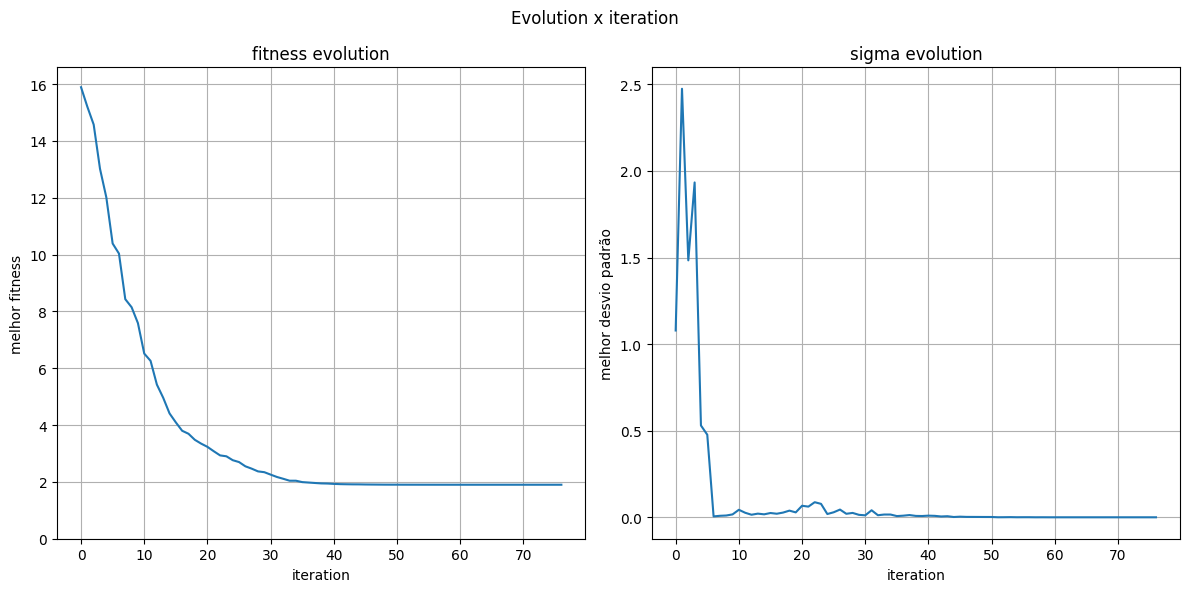

1.899788792481957 [-0.0007939061046146087, 0.0018086134855142717, -0.0006639417114679017, -0.0009912855372126751, 0.9309595284261439, 0.0013167380106855222, 0.9307280460962558, -0.0007810887865033315, -0.9298817737403315, 0.001237930603210959, -0.9301874149835189, 0.00042584343224488417, 7.587447657590875e-05, 0.0002591835520741688, 0.00012190917499175552, -0.9315696964922336, -0.9307716078051492, -0.0017146422388348694, -6.523188094071514e-05, 0.9309839514095051, -0.0002717277246477397, -0.0005574028581256068, 0.0006538531932032585, 0.0016930219533111159, 0.0010008210034720866, 0.0018677532155262208, 0.0004011912884265351, 0.0011527298896171338, -0.9303675087344874, 0.00014725403790012513]
Média: 4.137858184107345
Desvio Padrão: 1.152659407086234
Execuções com sucesso: 0 de 50


In [420]:
FITNESS_FUNC = ackley_funct
CROSSOVER_FUNC = local_discrete
SURV_SELECTION_FUNC = elitist

run_executions()

2.12008546263839 74 1.3404604491772685 84 0.9313426653041543 77 1.1553216714279455 89 1.501779866672074 74 1.1552307678259202 112 1.1552062383242725 79 1.7780327779492109 75 1.8997737947935787 75 1.8997747704370522 72 0.004412749318494225 78 1.5017705988118348 84 1.3404600335376746 87 1.3404471467775427 117 1.8997722378326363 81 1.340490668468306 80 1.778029807342595 81 1.7780252602636115 81 0.004807505511202681 78 0.0047728252698040485 114 1.8997724596327825 84 1.7780345536333617 82 0.9313448410961347 90 1.1551831343208652 88 1.501779622653594 77 0.933717699128263 90 1.1552078504843064 133 1.5017723460378432 81 1.1553292991844129 133 1.50177519699788 86 1.646252453750837 85 2.0133505862079457 81 1.5017834034301178 81 1.646255820186369 94 1.5017747166118665 89 1.3404477757565378 92 5.057990218649817 77 1.1552111802286942 90 1.8997743524021549 78 1.8997762912777643 85 0.004413301248014978 65 0.00441769430867156 72 1.646255994161376 87 1.3404717885643298 79 1.155180082238385 80 2.4083440

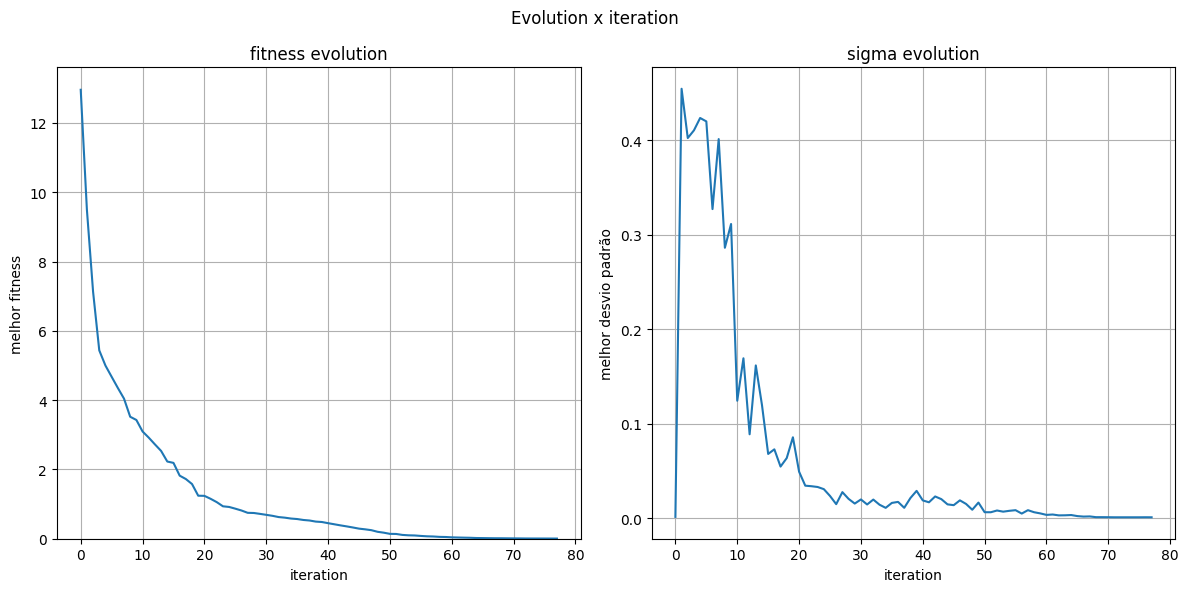

0.004412749318494225 [-0.0003124892109565798, 0.0012137383620243769, 0.00015774134040788556, -0.0032062776611224454, -0.0014199895855685762, -6.415471407070005e-05, 0.001428252698165213, 0.00011577536183693372, -0.00028746904393657773, 0.000931260442228659, -3.727289551623089e-05, -0.0013229272768358526, -0.0015125078020984464, 0.00020447026718257495, -0.0006088453675129317, 0.0008720468824748416, -0.00015039715351090324, 0.00013708721525865176, -0.0027803039798364308, -0.0007459246217446316, -0.000574388633586898, 0.0008652591898467198, 0.0006693591123402229, 0.0009300261412964445, -0.0008080032295584443, 0.0003028899851892187, -0.00029656147871871146, -0.0011771552902728835, 0.0006250695181198001, 0.0001891271407415893]
Média: 1.4934547280650314
Desvio Padrão: 0.8397678377006306
Execuções com sucesso: 5 de 50


In [421]:
FITNESS_FUNC = ackley_funct
CROSSOVER_FUNC = local_intermediary
SURV_SELECTION_FUNC = generational

run_executions()

3.3449953683147453 75 2.495450518313732 84 1.646250603362621 101 1.1553189297447628 102 0.9331482639060664 76 0.004100926391114701 100 1.778022106578558 84 2.0133491145329008 76 1.340451403401112 118 0.004798034942443241 116 1.646252822836502 86 2.2210000561259204 75 1.7780198787726147 79 1.7780253592025557 84 1.7780233882243945 86 0.004300585249478406 65 2.814127234868924 66 2.4959057371824547 75 0.004377672301999258 116 0.004338291323176424 129 0.9317461864049688 71 2.814130458182245 82 0.004680173268550636 83 2.0133478175570656 80 2.5799590308052633 78 1.1551839125318506 81 1.5017804149630938 76 1.6462547504048044 88 0.004886655502958082 96 1.6462502368297867 81 2.1200769076209487 76 1.6462574012424374 88 1.778028364189201 81 1.6462709472374795 91 0.9313457022350957 69 0.004236147620144681 99 0.004708501647276098 76 1.1551784907173865 82 0.004478726814582945 103 1.501776423559488 79 1.8997748579387452 86 1.5017752859673803 76 1.1553085868959383 128 1.3404744501708135 85 1.1551753162

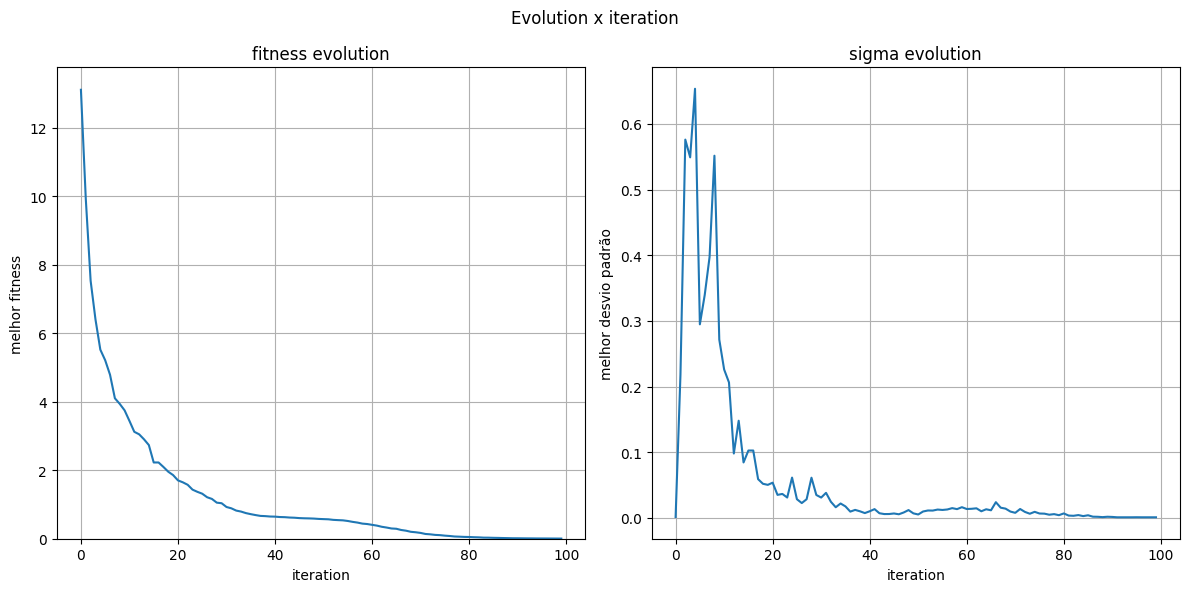

0.004100926391114701 [-0.0018811944518553792, -0.000683774603005006, 0.0011188141084882823, 0.0003443114066000193, 0.0005035239249253423, -9.251389344589714e-05, -0.0006940636084816782, -0.0006084541821596483, -0.0017842125607692326, 0.0007375123495946354, -3.543888179946249e-05, -0.0008378565863026027, -0.0008416028897823928, 0.00022944240666017347, 0.0010643991507910408, -9.588479280995892e-05, 0.0003754114601704151, 3.7063962474235016e-05, 0.00022983481001696967, 0.0030164258378756015, 0.0017965967744982116, -0.00030092855728623886, -0.0002216036121311941, -0.0004372619144510912, 0.001308924790393913, 0.0007250731336045094, 0.000104608863765901, -0.0015356993585649904, -0.0006438466356858776, 2.3567754013269465e-05]
Média: 1.413781782728846
Desvio Padrão: 0.9391721780267924
Execuções com sucesso: 11 de 50


In [422]:
FITNESS_FUNC = ackley_funct
CROSSOVER_FUNC = local_intermediary
SURV_SELECTION_FUNC = elitist

run_executions()

### Resultados com função de SCHWEFEL

In [423]:
RANGE_XI=(-500,500)
EPSILON_1 = 333

In [ ]:
FITNESS_FUNC = schwefel_funct
CROSSOVER_FUNC = local_discrete
SURV_SELECTION_FUNC = generational

run_executions()

In [ ]:
FITNESS_FUNC = schwefel_funct
CROSSOVER_FUNC = local_discrete
SURV_SELECTION_FUNC = elitist

run_executions()

In [ ]:
FITNESS_FUNC = schwefel_funct
CROSSOVER_FUNC = local_intermediary
SURV_SELECTION_FUNC = generational

run_executions()

In [ ]:
FITNESS_FUNC = schwefel_funct
CROSSOVER_FUNC = local_intermediary
SURV_SELECTION_FUNC = generational

run_executions()

# Estratégia Genética

## Versão 1